In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
# read the .csv files
train_labels=pd.read_csv('datasets/detection/train_labels.csv')
train_metadata=pd.read_csv('datasets/detection/train_metadata.csv')

In [3]:
train_labels.head()

,image_id,xmin,ymin,xmax,ymax
0,0001954c9f4a58f7ac05358b3cda8d20,0,277,345,709
1,00054819240f9d46378288b215dbcd3a,753,602,932,725
2,000dbf763348037b46558bbcb6a032ac,160,434,203,481
3,000e79208bebd8e84ce6c22fd8612a0d,70,534,211,586
4,000f13aff94499d03e3997afc55b0aa0,103,0,312,193


In [4]:
train_metadata.head()

,image_id,spacecraft_id,background_id
0,0001954c9f4a58f7ac05358b3cda8d20,24,247
1,00054819240f9d46378288b215dbcd3a,14,10
2,000dbf763348037b46558bbcb6a032ac,19,17
3,000e79208bebd8e84ce6c22fd8612a0d,14,15
4,000f13aff94499d03e3997afc55b0aa0,28,15


In [5]:
train_labels=train_labels.merge(train_metadata)

In [8]:
import shutil
import yaml
from pathlib import Path
PROJ_DIRECTORY = Path.cwd()
print(f"Current working directory is {PROJ_DIRECTORY}")

def createDir(dirToMake:Path):
    if not dirToMake.exists():
            dirToMake.mkdir(parents=True, exist_ok=True)

datasetdir = PROJ_DIRECTORY/ "datasets"

#now create the datasetdir
createDir(datasetdir)
#copy the dataset description yaml file from input to the dataset directory
shutil.copy('spaceship.yaml',str(datasetdir))
print("------done copying spaceship.yaml to working dir")

Current working directory is /home/gnas/Spacecraft_Detection
------done copying spaceship.yaml to working dir


In [9]:
PROJ_DIRECTORY

PosixPath('/home/gnas/Spacecraft_Detection')

In [10]:
def update_dataset():
    with open('spaceship.yaml', 'r') as file:
        settings = yaml.safe_load(file)
    print("----------before\n",settings)
    # settings['path']='/fast/Spacecraft_Detect_Estimation/images'
    settings['path']=str(PROJ_DIRECTORY / "datasets") + "/"
    # settings['test']= 'test/'
    settings['train']= 'train/'
    settings['val']= 'val/'
    with open('spaceship.yaml', 'w') as file:
        yaml.dump(settings, file)
    with open('spaceship.yaml', 'r') as file:
        settings = yaml.safe_load(file)
    print("----------after modification \n",settings)

update_dataset()

----------before
 {'names': {0: 'spacecraft0'}, 'path': '/home/gnas/Spacecraft_Detection/datasets/', 'train': 'train/', 'val': 'val/'}
----------after modification 
 {'names': {0: 'spacecraft0'}, 'path': '/home/gnas/Spacecraft_Detection/datasets/', 'train': 'train/', 'val': 'val/'}


In [11]:
# copy_from_folder = "/fast/Spacecraft_Detect_Estimation/images"
copy_from_folder = "datasets/detection/images"

#copy the images to their respective data folders
def create_data_folder(destination_folder, unique_images):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # unique_images = df['image_id'].unique()

    for img in unique_images:
        img_path = os.path.join(copy_from_folder, img )
        shutil.copy(img_path, destination_folder)

In [12]:
train_destination_folder = "datasets/train/images"
val_destination_folder = "datasets/val/images"

In [13]:
imsinfolder=os.listdir(copy_from_folder)
len(imsinfolder),imsinfolder[:3]

(25801,
 ['b742455259b7bd1c25d9b40247702049.png',
  '1727e476c0ef3347b4735520c246e196.png',
  '4241eceb23559d4a2e7295c7c2d3df63.png'])

In [3]:
# train_labels.head()

In [15]:
from sklearn.model_selection import GroupShuffleSplit, ShuffleSplit

gss = ShuffleSplit(n_splits=1, test_size=0.28, train_size=None, random_state=2024)
for i, (train_index, test_index) in enumerate(gss.split(train_labels)):
    print(f"Fold {i}:", len(train_index), len(test_index))
# gss = GroupShuffleSplit(n_splits=1, test_size=0.2, train_size=None, random_state=2024)
# for i, (train_index, test_index) in enumerate(gss.split(train_labels, train_labels, train_labels.spacecraft_id)):
#     print(f"Fold {i}:", len(train_index), len(test_index))


Fold 0: 18576 7225


In [17]:
train=train_labels.iloc[train_index,:]
test=train_labels.iloc[test_index,:]
train.shape, test.shape

((18576, 7), (7225, 7))

In [18]:
len([x for x in test.image_id if x+'.png' in imsinfolder])

7225

In [19]:
len([x for x in train.image_id if x+'.png' in imsinfolder])

18576

In [20]:
train_images=[x+'.png' for x in train.image_id.values if x+'.png' in imsinfolder]
val_images=[x+'.png' for x in test.image_id.values if x+'.png' in imsinfolder]
len(train_images), len(val_images)

(18576, 7225)

In [ ]:
create_data_folder(train_destination_folder, train_images)
create_data_folder(val_destination_folder, val_images)

In [21]:
img=cv2.imread(train_destination_folder+'/'+os.listdir(train_destination_folder)[0])

In [22]:
train_destination_folder

'datasets/train/images'

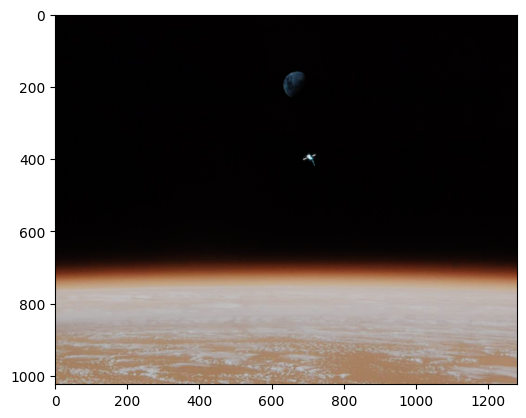

(1024, 1280)

In [23]:

plt.imshow(img)
plt.show()
img_height, img_width=img.shape[:2]
img_height, img_width

In [24]:
def create_label_folder(label_dir, dataframe):
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)

    unique_images = dataframe['image_id'].unique()

    for i,img in zip(tqdm(range(len(unique_images))), unique_images):
        imgarY, imgarX = cv2.imread(copy_from_folder+'/'+img+'.png').shape[:2]
        df = dataframe[dataframe['image_id'] == img]
        output_lines = []
        for index, row in df.iterrows():

            output_lines.append(f'0 {(0.5*row.xmin+0.5*row.xmax)/imgarX} {(0.5*row.ymin+0.5*row.ymax)/imgarY} {(row.xmax-row.xmin)/imgarX} {(row.ymax-row.ymin)/imgarY}')

        with open(f"{label_dir}/{img}.txt", 'w') as f:
            for line in output_lines:
                f.write(line + '\n')

In [27]:
train_df=train.loc[train.image_id.isin([x[:-4] for x in train_images]),:].reset_index(drop=True)
val_df=test.loc[test.image_id.isin([x[:-4] for x in val_images]),:].reset_index(drop=True)
train_df.shape, val_df.shape

((18576, 7), (7225, 7))

In [29]:
create_label_folder("datasets/train/labels", train_df)
create_label_folder("datasets/val/labels", val_df)

# Train

In [28]:
# Disable wandb
# This is just a nuance that i prefer to disable for easier visualization
# import wandb
import os
# wandb.disabled = True
os.environ['WANDB_DISABLED'] = 'true'
# !wandb disabled
#remove if there are previous artifacts of project dir


In [1]:
from ultralytics import YOLO
datayml = 'spaceship.yaml'
model = YOLO('yolov8n.pt')
results = model.train(data=datayml,
            imgsz=640,
            epochs=3,
#             fraction=0.1,
            batch=32,
            device=[0],#'cpu',
            project ="finetune",
#             freeze = 20,
            plots=True)

In [39]:
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = 640,
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.2.6 🚀 Python-3.8.0 torch-1.8.1+cu111 CUDA:1 (GeForce GTX 1080, 8120MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'finetune/train20/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)

ONNX: starting export with onnx 1.16.0 opset 12...
ONNX: export success ✅ 6.9s, saved as 'finetune/train20/weights/best.onnx' (11.7 MB)

Export complete (7.4s)
Results saved to /home/gnas/Spacecraft_Detection/finetune/train20/weights
Predict:         yolo predict task=detect model=finetune/train20/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=finetune/train20/weights/best.onnx imgsz=640 data=spaceship.yaml  
Visualize:       https://netron.app


'finetune/train20/weights/best.onnx'

### Evaluate on test dataset

In [2]:
test_results =model.val(data=datayml,split='val')

# Visualize results

In [41]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#import cv2
def plot_image_with_bbox(image_path, results):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for result in results:
            for box in result.boxes:
                left, top, right, bottom = np.array(box.xyxy.cpu(), dtype=np.int64).squeeze()
                width = right - left
                height = bottom - top
                center = (left + int((right-left)/2), top + int((bottom-top)/2))
                label = results[0].names[int(box.cls)]
                confidence = float(box.conf.cpu())
                rect = patches.Rectangle((left, top), width, height, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

    plt.axis('off')  # Turn off axis
    plt.show()


image 1/1 /fast/Spacecraft_Pose_Estimation/images/fcae893bd9/021.png: 512x640 2 spacecraft0s, 43.9ms
Speed: 3.6ms preprocess, 43.9ms inference, 4.0ms postprocess per image at shape (1, 3, 512, 640)


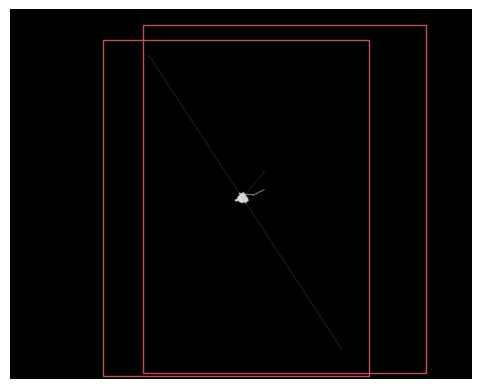

In [42]:

filename = '/fast/Spacecraft_Pose_Estimation/images/fcae893bd9/021.png'
# Run inference on with default arguments using finetuned model
res_tuned = model.predict(filename, imgsz=640)
plot_image_with_bbox(filename, res_tuned)
